In [1]:
from gurobipy import *


# In[3]:


# create model
m = Model("GEP")


# In[4]:


######## INPUT MODEL PARAMETERS ##############
num_years = 10

## Input generation cost by thermal, solar and wind， split thermal to coal and natural gas
FUELc  = 17  # $/MWh
FUELng = 18  # $/MWh avg combined cycle 

VOMc  = 4  # $/MWh
VOMng = 2  # $/MWh
VOMw  = 0  # $/MWh
VOMs  = 0  # $/MWh

CGc  = FUELc  + VOMc   # $/MWh
CGng = FUELng + VOMng  # $/MWh
CGw  = VOMw            # $/MWh
CGs  = VOMs            # $/MWh

CG = [CGc, CGng, CGw, CGs] # $/MWh

### Input investment cost by thermal, solar and wind

# CAPEX	= ConFinFActor * (OCC * CapRegMult + GCC)
CAPEXc  = 4150  # $/kW Coal-new-AvgCF
#CAPEXc  = 4150  # $/kW Coal-new-HighCF
CAPEXng = 1088  # $/kW Gas CC AvgCF
#CAPEXng = 1088  # $/kW Gas CC HighCF
CAPEXw  = 1926 # $/kW Class 7
CAPEXs  = 1600 # $/kW LA

# Fixed Operating Expenses	FOM = input in $/kW
FOMc  = 40 # $/kW - year
FOMng = 13 # $/kW-year Gas-CC-AvgCF
#FOMng = 13 # $/kW-year Gas-CC-HighCF
FOMw  = 43 # $/kW - year
FOMs  = 19 # $/kW - year

CIc  = (CAPEXc  + num_years*FOMc)  * (10^-3)  # $/MW
CIng = (CAPEXng + num_years*FOMng) * (10^-3)  # $/MW
CIs  = (CAPEXs  + num_years*FOMs)  * (10^-3)  # $/MW
CIw  = (CAPEXw  + num_years*FOMw)  * (10^-3)  # $/MW

CI = [CIc, CIng, CIs, CIw] # $/MW

## CRF by technology
CRFc  = 0.052
CRFng = 0.05
CRFw  = 0.047
CRFs  = 0.043 # real-mid

## The number of hours coal, natual gas, solar and wind units are operating respectively in a single year 
Nhc  =   4695  # Coal-new-AvgCF
#Nhc  =  7446 # Coal-new-HighCF
Nhng = 4818 # Gas-CC-AvgCF
# Nhng = 7621 # Gas-CC-HighCF
Nhw  = 3023 # Class 7 Wind
Nhs  = 2793 # Utility PV - LA
Nh = [Nhc, Nhng, Nhw, Nhs] # ATB table data 
Nh = [8760,8760,4380,5694] 

## Input annualized future projection of demand from year 2021-2030, expressed in unit of MW
# “Adopted 2019 Integrated Energy Policy Report,” n.d., 412.
D = 321300 * (10^3) #MWh   CEDU 2018 mid - 2030 # Replace the TESTING NUMBER
#D_2020 = 280000 #GWh

## Input capacity factors for solar and wind, assume capacity factor for coal and natural gas is 1.
# https://drive.google.com/file/d/1LPtT65RnJX-_ZS1eFr5GIWIGAC2QI_cr/view?usp=sharing
# https://www.eia.gov/electricity/monthly/epm_table_grapher.php?t=epmt_6_07_ahttps://www.eia.gov/electricity/monthly/epm_table_grapher.php?t=epmt_6_07_a
Fc  = 0.402 
#Fc = 0.85 # Coal-new-HighCF from ATB table
Fng = 0.566
#Fng = 0.87  # Gas-CC-HighCF from ATB table
Fs  = 0.32  # LA from ATB table
Fw  = 0.354 # assuming class 7

#we can play with these variables in sensitivity test

## Set Target for Renewable Penetration in 10 years
rp=0.4

## Power expansion limit i.e. the maximum that can be built for thermal, solar and wind technologies
PiMax=[400,200,300,400] # Replace the TESTING NUMBER


ModuleNotFoundError: No module named 'gurobipy'

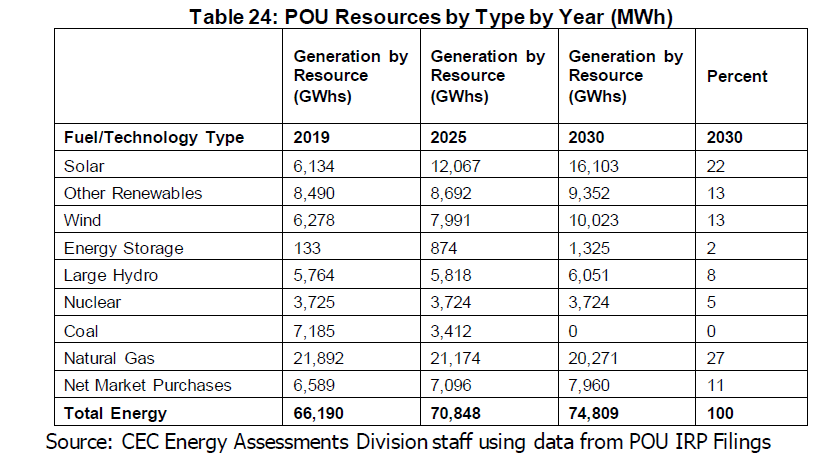

In [ ]:
##### Config Scenarios: Baseline / Public Health #######

### Health care cost $/MWh ###
# Machol, Ben, and Sarah Rizk. “Economic Value of U.S. Fossil Fuel Electricity Health Impacts.” Environment International 52 (February 1, 2013): 75–80. https://doi.org/10.1016/j.envint.2012.03.003.
CH   = [0, 0] # CH=0 under baseline scenario

CHc  = 0.45 * (10^-3)# $/MWh
CHng = 0.02 * (10^-3) # $/MWh
CH = [CHc, CHng] # CH>0 under public health scenario


In [ ]:

# Create decision variables representing power generation & capacity expansions:  
# technologies: coal, natural gas, wind and solar
Pg_c = m.addVar(vtype=GRB.CONTINUOUS, name="Pg_c"); 
Pg_n = m.addVar(vtype=GRB.CONTINUOUS, name="Pg_n"); 
Pg_s = m.addVar(vtype=GRB.CONTINUOUS, name="Pg_s");
Pg_w = m.addVar(vtype=GRB.CONTINUOUS, name="Pg_w");
Pi_c = m.addVar(vtype=GRB.CONTINUOUS, name="Pi_c"); 
Pi_n = m.addVar(vtype=GRB.CONTINUOUS, name="Pi_n"); 
Pi_s = m.addVar(vtype=GRB.CONTINUOUS, name="Pi_s");
Pi_w = m.addVar(vtype=GRB.CONTINUOUS, name="Pi_w");


In [ ]:

# Set objective
m.setObjective(Nh[0]*Pg_c + Nh[1]*Pg_n + Nh[2]*Pg_s + Nh[3]*Pg_w + CI[0]*Pi_c + CI[1]*Pi_n + CI[2]*Pi_s + CI[3]*Pi_w + CH[0]*Nh[0]*Pg_c+ CH[1]*Nh[1]*Pg_n, GRB.MINIMIZE)


In [ ]:
# Add constraints:
m.addConstr(Pg_c + Pg_n + Pg_s + Pg_w >= D, "c0")  # Power balance constraint

m.addConstr(Pg_c <= Pi_c, "c1")    # power output lower and upper limits
m.addConstr(Pg_n <= Pi_n, "c2")
m.addConstr(Pg_s <= Pi_s, "c3")
m.addConstr(Pg_w <= Pi_w, "c4")
m.addConstr(Pg_c >= 0, "c5")
m.addConstr(Pg_n >= 0, "c6")
m.addConstr(Pg_s >= 0, "c7")
m.addConstr(Pg_w >= 0, "c8")

m.addConstr(Nh[0]*Pg_c + Nh[1]*Pg_n + Nh[2]*Pg_s + Nh[3]*Pg_w >= rp*D, "c9")  # renewable penetration target constraint 

m.addConstr(Pi_c <= PiMax[0], "c10")  # limit of the maximum buildout for each generation technology
m.addConstr(Pi_n <= PiMax[0], "c11")
m.addConstr(Pi_s <= PiMax[1], "c12") 
m.addConstr(Pi_w <= PiMax[2], "c13") 

In [ ]:
# Optimize
m.optimize()

In [ ]:
# In[10]:


# printout decision variable values
m.getVars()
for v in m.getVars(): print(v.varName, v.x)
# printout objective values
print('Obj: %g' % m.objVal)

In [ ]:
# ## Data Analytics

# In[14]:


import matplotlib.pyplot as plt
# Pie chart of generation mix, where the slices will be ordered and plotted counter-clockwise:

Pg_c_star=m.getVars()[0].x
Pg_n_star=m.getVars()[1].x
Pg_s_star=m.getVars()[2].x
Pg_w_star=m.getVars()[3].x
Pi_c_star=m.getVars()[4].x
Pi_n_star=m.getVars()[5].x
Pi_s_star=m.getVars()[6].x
Pi_w_star=m.getVars()[7].x

labels = 'Coal', 'Natural Gas', 'Solar', 'Wind'
genMix = [Pg_c_star, Pg_n_star, Pg_s_star, Pg_w_star]
expCap = [Pi_c_star, Pi_n_star, Pi_s_star, Pi_w_star]
sizes = [25, 25, 25, 25] ## just using pseudo sizes matrix for pie chart demo, need to replace it with genMix
explode = (0, 0, 0.1, 0)  # only "explode" the 2nd slice (i.e. 'Solar')

fig1, (ax1,ax2) = plt.subplots(1,2)
ax1.pie(genMix, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("Optimal Generation Mix \nin next 10 years")

ax2.pie(expCap, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax2.set_title("Optimal Capacity Expansion \nin next 10 years")
plt.show()